In [1]:
from __future__ import print_function

from IPython import display

import math
import matplotlib
import sklearn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numpy import radians, cos, sin, arcsin, arccos, sqrt, pi, arctan2, degrees, arctan
import itertools

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
tqdm.pandas(tqdm_notebook)

import osrm
from joblib import dump, load

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from natsort import natsorted
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn import metrics

from xgboost import XGBRegressor

pd.options.display.max_rows = 10

In [2]:
def coord_prec(coord):
    precision =  math.pow(10, 3)
    new_coord = float((int(precision * coord)))/precision
    return new_coord
def rmsle(ypred, ytest) :
    assert len(ytest) == len(ypred)
    return np.sqrt(np.mean((np.log1p(ypred) - np.log1p(ytest))**2))
def cal_bearing(lat1, lon1, lat2, lon2):
    """
    Calculates the bearing between two points using the formula
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    """
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1

    x = sin(dlon) * cos(lat2)
    y1 = cos(lat1) * sin(lat2)
    y2 = sin(lat1) * cos(lat2) * cos(dlon)
    y = y1 - y2

    initial_bearing = arctan2(x, y)

    initial_bearing = degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [3]:
taxi = load('/mnt/hgfs/FYP/porto_sampled.pkl')  

In [4]:
taxi.drop('Unnamed: 0', axis = 1, inplace = True)
taxi.reset_index(drop = True, inplace = True)

In [5]:
taxi.columns = ['pickup_time', 'pickup_longitude', 'pickup_latitude', 'ID',
       'distance_travelled', 'time_elapsed_seconds', 'speed m/s', 'speed kmh',
       'bearing', 'bearing_diff', 'rate_of_turn', 'acceleration',
       'distance_travelled_sum2', 'longitude_mean2', 'latitude_mean2',
       'distance_travelled_mean2', 'speed m/s_mean2', 'speed kmh_mean2',
       'bearing_mean2', 'bearing_diff_mean2', 'rate_of_turn_mean2',
       'acceleration_mean2', 'longitude_stddev2', 'latitude_stddev2',
       'distance_travelled_stddev2', 'speed m/s_stddev2', 'speed kmh_stddev2',
       'bearing_stddev2', 'bearing_diff_stddev2', 'rate_of_turn_stddev2',
       'acceleration_stddev2', 'distance_travelled_kurt2', 'speed m/s_kurt2',
       'speed kmh_kurt2', 'bearing_kurt2', 'bearing_diff_kurt2',
       'rate_of_turn_kurt2', 'acceleration_kurt2', 'distance_travelled_skew2',
       'speed m/s_skew2', 'speed kmh_skew2', 'bearing_skew2',
       'bearing_diff_skew2', 'rate_of_turn_skew2', 'acceleration_skew2',
       'dropoff_time', 'dropoff_longitude', 'dropoff_latitude']

In [6]:
taxi

,pickup_time,pickup_longitude,pickup_latitude,ID,distance_travelled,time_elapsed_seconds,speed m/s,speed kmh,bearing,bearing_diff,...,distance_travelled_skew2,speed m/s_skew2,speed kmh_skew2,bearing_skew2,bearing_diff_skew2,rate_of_turn_skew2,acceleration_skew2,dropoff_time,dropoff_longitude,dropoff_latitude
0,2013-07-15 14:16:33,-8.607177,41.151177,20000040,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-15 14:16:48,-8.607042,41.151132
1,2013-07-15 14:16:33,-8.607177,41.151177,20000040,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-15 14:17:03,-8.606646,41.151267
2,2013-07-15 14:16:33,-8.607177,41.151177,20000040,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-15 14:17:18,-8.606205,41.152068
3,2013-07-15 14:16:33,-8.607177,41.151177,20000040,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-15 14:17:33,-8.605800,41.152752
4,2013-07-15 14:16:33,-8.607177,41.151177,20000040,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-15 14:17:48,-8.605377,41.153382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2596061,2013-07-02 08:50:10,-8.628651,41.158764,20000046,0.110427,15.0,7.361822,26.502560,152.763402,21.097608,...,0.298048,0.298048,0.298048,1.975752,1.252292,1.252292,-0.262774,2013-07-02 08:50:40,-8.628462,41.160699
2596062,2013-07-02 08:50:10,-8.628651,41.158764,20000046,0.110427,15.0,7.361822,26.502560,152.763402,21.097608,...,0.298048,0.298048,0.298048,1.975752,1.252292,1.252292,-0.262774,2013-07-02 08:50:55,-8.629074,41.160924
2596063,2013-07-02 08:50:25,-8.628660,41.159628,20000046,0.096183,15.0,6.412200,23.083919,179.550662,26.787260,...,0.295691,0.295691,0.295691,1.599079,1.085225,1.085225,0.199650,2013-07-02 08:50:40,-8.628462,41.160699
2596064,2013-07-02 08:50:25,-8.628660,41.159628,20000046,0.096183,15.0,6.412200,23.083919,179.550662,26.787260,...,0.295691,0.295691,0.295691,1.599079,1.085225,1.085225,0.199650,2013-07-02 08:50:55,-8.629074,41.160924


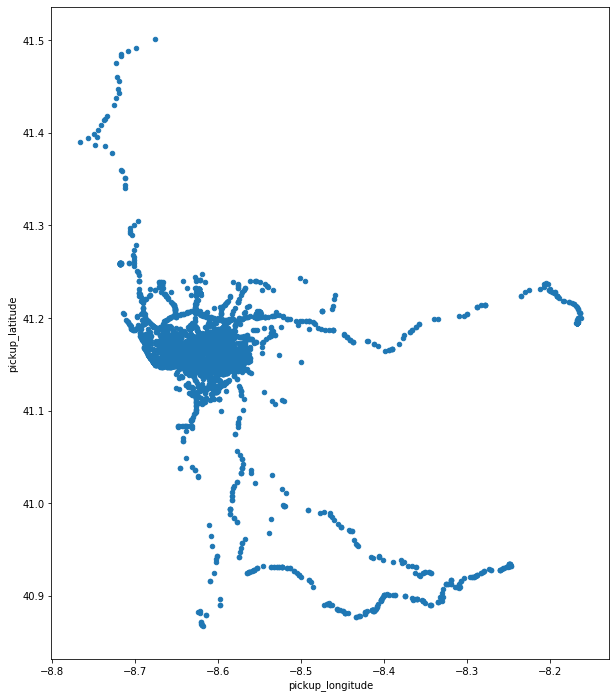

In [7]:
taxi.sample(10000).plot(kind = 'scatter', x = 'pickup_longitude', y = 'pickup_latitude', figsize = (10,12))

In [8]:
taxi.head(10)

,pickup_time,pickup_longitude,pickup_latitude,ID,distance_travelled,time_elapsed_seconds,speed m/s,speed kmh,bearing,bearing_diff,...,distance_travelled_skew2,speed m/s_skew2,speed kmh_skew2,bearing_skew2,bearing_diff_skew2,rate_of_turn_skew2,acceleration_skew2,dropoff_time,dropoff_longitude,dropoff_latitude
0,2013-07-15 14:16:33,-8.607177,41.151177,20000040,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-15 14:16:48,-8.607042,41.151132
1,2013-07-15 14:16:33,-8.607177,41.151177,20000040,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-15 14:17:03,-8.606646,41.151267
2,2013-07-15 14:16:33,-8.607177,41.151177,20000040,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-15 14:17:18,-8.606205,41.152068
3,2013-07-15 14:16:33,-8.607177,41.151177,20000040,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-15 14:17:33,-8.605800,41.152752
4,2013-07-15 14:16:33,-8.607177,41.151177,20000040,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-15 14:17:48,-8.605377,41.153382
5,2013-07-15 14:16:33,-8.607177,41.151177,20000040,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-15 14:18:03,-8.606088,41.153634
6,2013-07-15 14:16:33,-8.607177,41.151177,20000040,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-15 14:18:18,-8.607942,41.153643
7,2013-07-15 14:16:33,-8.607177,41.151177,20000040,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-15 14:18:33,-8.609508,41.153589
8,2013-07-15 14:16:33,-8.607177,41.151177,20000040,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-15 14:18:48,-8.609688,41.153706
9,2013-07-15 14:16:33,-8.607177,41.151177,20000040,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-15 14:19:03,-8.609652,41.153760


In [6]:
def haversine(lat1, lon1, lat2, lon2):
    #ensure using numpy and not math, or pandas series cannot be passed
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a))
    r = 6378.137 ##radius of earth km
    return c * r

def compute_dist(df):
    next_df = df.shift(1)
    dist = haversine(df.iloc[:,0], df.iloc[:,1],
                    next_df.iloc[:,0], next_df.iloc[:,1])
    return dist

def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
    
    #the Haversine version
    foob = df[["pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude"]].astype(float)
    df['hav_dist_lat'] = haversine(foob.iloc[:,0], foob.iloc[:,1],foob.iloc[:,2],foob.iloc[:,1])
    df['hav_dist_lon'] = haversine(foob.iloc[:,2], foob.iloc[:,1],foob.iloc[:,2],foob.iloc[:,3])
    
    
def convert_km(df):
    df['abs_diff_longitude'] = df.abs_diff_longitude*80.4
    df['abs_diff_latitude'] = df.abs_diff_latitude*111

In [7]:
add_travel_vector_features(taxi)
convert_km(taxi)

taxi['Euclidean'] = (taxi.abs_diff_latitude**2 + taxi.abs_diff_longitude**2)**0.5 
    
taxi['manh_length_hav'] = taxi.hav_dist_lat + taxi.hav_dist_lon
taxi['manh_length_euc'] = taxi.abs_diff_latitude + taxi.abs_diff_longitude

taxi['minkowski_0.9'] = (taxi.hav_dist_lat**0.92 + taxi.hav_dist_lon**0.92)**(1/0.92)
taxi['dist_to_dest'] = haversine(taxi['pickup_latitude'].values, taxi['pickup_longitude'].values, taxi['dropoff_latitude'].values, taxi['dropoff_longitude'].values)


In [8]:
taxi['pickup_lat_cut'] = taxi.pickup_latitude.apply(coord_prec)
taxi['pickup_lon_cut'] = taxi.pickup_longitude.apply(coord_prec)
taxi['dropoff_lat_cut'] = taxi.dropoff_latitude.apply(coord_prec)
taxi['dropoff_lon_cut'] = taxi.dropoff_longitude.apply(coord_prec)
taxi['bearing_to_dest'] = cal_bearing(taxi.iloc[:,1], taxi.iloc[:,2],taxi.iloc[:,8],taxi.iloc[:,9])

In [9]:
taxi['pickup_weekday'] = taxi['pickup_time'].dt.weekday
taxi['pickup_hour_weekofyear'] = taxi['pickup_time'].dt.weekofyear
taxi['pickup_hour'] = taxi['pickup_time'].dt.hour
taxi['pickup_minute'] = taxi['pickup_time'].dt.minute
taxi['pickup_dt'] = (taxi['pickup_time'] - taxi['pickup_time'].min()).dt.total_seconds()
taxi['pickup_week_hour'] = taxi['pickup_weekday'] * 24 + taxi['pickup_hour']

In [10]:
coords = np.vstack((taxi[['pickup_latitude', 'pickup_longitude']].values,
                    taxi[['dropoff_latitude', 'dropoff_longitude']].values))
pca = PCA()
pca = pca.fit(coords)
taxi['pickup_pca0'] = pca.transform(taxi[['pickup_latitude', 'pickup_longitude']])[:, 0]
taxi['pickup_pca1'] = pca.transform(taxi[['pickup_latitude', 'pickup_longitude']])[:, 1]
taxi['dropoff_pca0'] = pca.transform(taxi[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
taxi['dropoff_pca1'] = pca.transform(taxi[['dropoff_latitude', 'dropoff_longitude']])[:, 1]


In [11]:
km = KMeans(
    n_clusters=50, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

# km = load('kmeans_0310.joblib')
coordinates = taxi[["pickup_longitude", "pickup_latitude"]].head(100000).values
km.fit_predict(coordinates)

coordinates = taxi[["pickup_longitude", "pickup_latitude"]].values
pickup_km = km.predict(coordinates)

coordinates = taxi[["dropoff_longitude", "dropoff_latitude"]].values
dropoff_km = km.predict(coordinates)


taxi["pickup_cluster"] = pickup_km
taxi["dropoff_cluster"] = dropoff_km

In [12]:
taxi['duration'] = taxi['dropoff_time'] - taxi['pickup_time']
taxi['duration'] = taxi['duration'].dt.total_seconds().astype(int)

In [13]:
taxi = taxi[taxi['duration'] > 60]
taxi = taxi[taxi['duration'] < 4000]

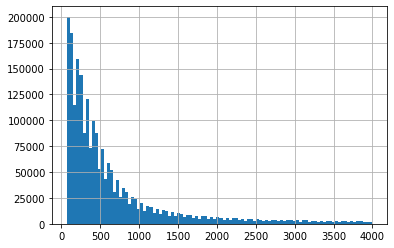

In [14]:
taxi['duration'].hist(bins = 100)

In [17]:
taxi.columns

Index(['pickup_time', 'pickup_longitude', 'pickup_latitude', 'ID',
       'distance_travelled', 'time_elapsed_seconds', 'speed m/s', 'speed kmh',
       'bearing', 'bearing_diff', 'rate_of_turn', 'acceleration',
       'distance_travelled_sum2', 'longitude_mean2', 'latitude_mean2',
       'distance_travelled_mean2', 'speed m/s_mean2', 'speed kmh_mean2',
       'bearing_mean2', 'bearing_diff_mean2', 'rate_of_turn_mean2',
       'acceleration_mean2', 'longitude_stddev2', 'latitude_stddev2',
       'distance_travelled_stddev2', 'speed m/s_stddev2', 'speed kmh_stddev2',
       'bearing_stddev2', 'bearing_diff_stddev2', 'rate_of_turn_stddev2',
       'acceleration_stddev2', 'distance_travelled_kurt2', 'speed m/s_kurt2',
       'speed kmh_kurt2', 'bearing_kurt2', 'bearing_diff_kurt2',
       'rate_of_turn_kurt2', 'acceleration_kurt2', 'distance_travelled_skew2',
       'speed m/s_skew2', 'speed kmh_skew2', 'bearing_skew2',
       'bearing_diff_skew2', 'rate_of_turn_skew2', 'acceleration_skew

## Control - No speed info - like NYC data

In [15]:
x = taxi[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',
       'pickup_lat_cut', 'pickup_lon_cut', 'dropoff_lat_cut',
       'dropoff_lon_cut', 'pickup_weekday', 'pickup_hour_weekofyear',
       'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour',
       'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1',
       'pickup_cluster', 'dropoff_cluster']]
y = taxi['duration']

In [16]:
X_train, X_validation, Y_train, Y_validation =  train_test_split(x,y, test_size = 0.1, random_state = 42)
del x
del y

In [17]:
# x_train_prescale = X_train.values
# x_validation_prescale = X_validation.values

In [17]:
control_scaler_nodist = sklearn.preprocessing.StandardScaler()
x_train = control_scaler_nodist.fit_transform(X_train.values)
x_test = control_scaler_nodist.transform(X_validation.values)
del X_train

In [20]:
xg_reg_nodist = XGBRegressor(objective ='reg:squarederror', n_jobs = -1, min_child_weight = 3, max_depth = 12, learning_rate = 0.1,
                      gamma = 0.1, colsample_bytree = 0.5, alpha = 10, n_estimators = 370)

In [23]:
xg_reg_nodist.fit(x_train,Y_train)


/home/ericlow/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=12, min_child_weight=3, missing=None, n_estimators=370,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [24]:
y_pred = xg_reg_nodist.predict(x_test)
print("MAE: ", metrics.mean_absolute_error(Y_validation, y_pred), "\nRMSLE: ", rmsle(Y_validation, y_pred))

MAE:  46.339813810753405 
RMSLE:  0.2252817632695172


/home/ericlow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log1p
  import sys


In [1]:
import gc
gc.collect()

0

In [37]:
dump(xg_reg_nodist, 'xgboost2203_control.pkl')

['xgboost2203_control.pkl']

In [18]:
xg_reg_nodist = load('xgboost2203_control.pkl')

In [22]:
bins = pd.cut(taxi['duration'], 20)
taxi.groupby(bins)['duration'].agg(['count'])

,count
duration,
"(71.085, 270.75]",802513
"(270.75, 466.5]",469559
"(466.5, 662.25]",279079
"(662.25, 858.0]",164575
"(858.0, 1053.75]",103457
...,...
"(3011.25, 3207.0]",14153
"(3207.0, 3402.75]",13176
"(3402.75, 3598.5]",12000


In [50]:
X_validation.merge(Y_validation, left_index=True, right_index=True).groupby(pd.cut(Y_validation, 20))

In [ ]:
errors_nodist = pd.DataFrame()
tt = []
for bin_name, group in X_validation.merge(Y_validation, left_index=True, right_index=True).groupby(pd.cut(Y_validation, 20)):
    print(bin_name)
    group.drop('duration', axis = 1, inplace = True)
    y_grp = Y_validation.loc[group.index]
    y_pred= xg_reg_nodist.predict(control_scaler_nodist.transform(group.values))
    
    aa = metrics.mean_absolute_error(y_grp, y_pred)
    bb = rmsle(y_grp, y_pred)
    
    fooh = pd.DataFrame([aa, bb], columns = [bin_name])
    errors_nodist = pd.concat([errors_nodist, fooh], axis = 1)
    
    predict_results = xg_reg_nodist.predict(control_scaler_nodist.transform(group))
    predict_res = pd.DataFrame(predict_results.flatten() - y_grp)
# #     print(predict_res.describe())
# #     predict_res.hist(bins = 100)
    tt.append(predict_res.values)
    
# display.display(errors_dist)

In [20]:
errors_nodist = errors_nodist.rename(index = {0: 'loss_nostats', 1:'rmsle_nostats'})

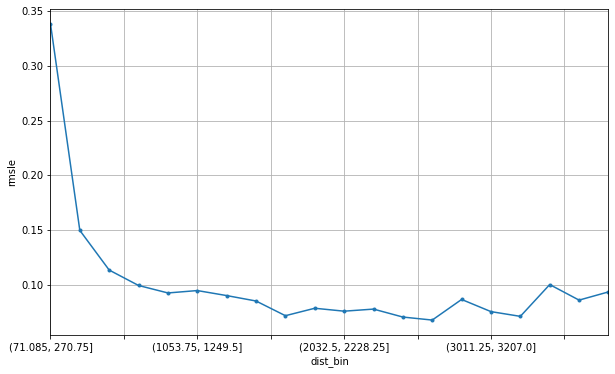

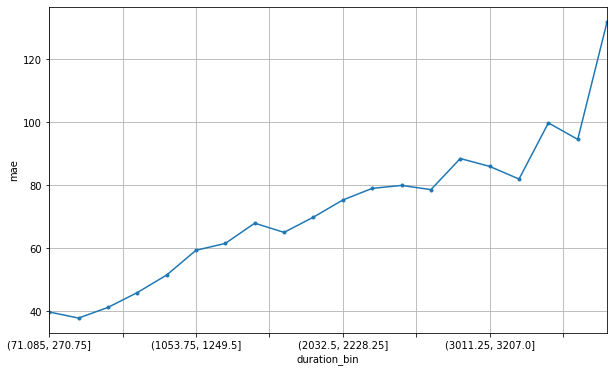

In [21]:
errors_nodist.loc['rmsle_nostats'].T.plot(figsize = (10 ,6 ), style ='.-')
plt.xlabel('dist_bin')
plt.ylabel('rmsle')
plt.grid(True)

plt.show()
errors_nodist.loc['loss_nostats'].T.plot(figsize = (10 ,6 ), style ='.-')
plt.xlabel('duration_bin')
plt.ylabel('mae')
plt.grid(True)

In [22]:
errors_nodist

,"(71.085, 270.75]","(270.75, 466.5]","(466.5, 662.25]","(662.25, 858.0]","(858.0, 1053.75]","(1053.75, 1249.5]","(1249.5, 1445.25]","(1445.25, 1641.0]","(1641.0, 1836.75]","(1836.75, 2032.5]","(2032.5, 2228.25]","(2228.25, 2424.0]","(2424.0, 2619.75]","(2619.75, 2815.5]","(2815.5, 3011.25]","(3011.25, 3207.0]","(3207.0, 3402.75]","(3402.75, 3598.5]","(3598.5, 3794.25]","(3794.25, 3990.0]"
loss_nostats,39.801486,37.863503,41.235665,45.946056,51.520425,59.374076,61.565620,67.989232,65.064237,69.912337,75.344192,79.034469,79.982596,78.635504,88.516008,86.015118,81.999599,99.824052,94.597231,131.998259
rmsle_nostats,0.338633,0.149771,0.113540,0.099462,0.092632,0.094820,0.090241,0.085282,0.071863,0.078666,0.075996,0.077897,0.070630,0.067876,0.086697,0.075588,0.071262,0.100291,0.086098,0.093588


## With Stats

In [29]:
taxi.columns

Index(['pickup_time', 'pickup_longitude', 'pickup_latitude', 'ID',
       'distance_travelled', 'time_elapsed_seconds', 'speed m/s', 'speed kmh',
       'bearing', 'bearing_diff', 'rate_of_turn', 'acceleration',
       'distance_travelled_sum2', 'longitude_mean2', 'latitude_mean2',
       'distance_travelled_mean2', 'speed m/s_mean2', 'speed kmh_mean2',
       'bearing_mean2', 'bearing_diff_mean2', 'rate_of_turn_mean2',
       'acceleration_mean2', 'longitude_stddev2', 'latitude_stddev2',
       'distance_travelled_stddev2', 'speed m/s_stddev2', 'speed kmh_stddev2',
       'bearing_stddev2', 'bearing_diff_stddev2', 'rate_of_turn_stddev2',
       'acceleration_stddev2', 'distance_travelled_kurt2', 'speed m/s_kurt2',
       'speed kmh_kurt2', 'bearing_kurt2', 'bearing_diff_kurt2',
       'rate_of_turn_kurt2', 'acceleration_kurt2', 'distance_travelled_skew2',
       'speed m/s_skew2', 'speed kmh_skew2', 'bearing_skew2',
       'bearing_diff_skew2', 'rate_of_turn_skew2', 'acceleration_skew

In [42]:
x = taxi.drop(['pickup_time', 'ID', 'dropoff_time', 'duration'], axis = 1)
y = taxi['duration']

In [43]:
X_train, X_validation, Y_train, Y_validation =  train_test_split(x,y, test_size = 0.1, random_state = 43)
del x
del y

In [19]:
# x_train_prescale = X_train.values
# x_validation_prescale = X_validation.values

In [34]:
control_scaler_nodist_speed = sklearn.preprocessing.StandardScaler()
x_train = control_scaler_nodist_speed.fit_transform(X_train.values)
del X_train
x_test = control_scaler_nodist_speed.transform(X_validation.values)
# del X_validation

In [57]:
# del x
# del y
# del X_train
# # del x_train
# # del x_test
# # del X_validation
# del Y_train
gc.collect()

98

In [25]:
xg_reg_nodist_speed = XGBRegressor(objective ='reg:squarederror', n_jobs = -1, min_child_weight = 3, max_depth = 12, learning_rate = 0.1,
                      gamma = 0.1, colsample_bytree = 0.5, alpha = 10, n_estimators = 370)

In [26]:
xg_reg_nodist_speed.fit(x_train,Y_train)


/home/ericlow/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=12, min_child_weight=3, missing=None, n_estimators=370,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [27]:
y_pred = xg_reg_nodist_speed.predict(x_test)
print("MAE: ", metrics.mean_absolute_error(Y_validation, y_pred), "\nRMSLE: ", rmsle(Y_validation, y_pred))

MAE:  55.08904493096334 
RMSLE:  0.24139658310346473


/home/ericlow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log1p
  import sys


In [41]:
import gc
gc.collect()

11045

In [29]:
dump(xg_reg_nodist_speed, 'xgbooststats2303.pkl')

['xgbooststats2303.pkl']

In [17]:
xg_reg_nodist = load('xgboost1612.pkl')

In [ ]:
bins = pd.cut(taxi['duration'], 20)
taxi.groupby(bins)['duration'].agg(['count'])

In [26]:
xg_reg_nodist_speed = load('xgbooststats2303.pkl')

In [63]:
X_validation.merge(Y_validation, left_index=True, right_index=True).groupby(pd.cut(Y_validation, 20))

In [ ]:
errors_nodist_speed = pd.DataFrame()
tt = []
for bin_name, group in X_validation.merge(Y_validation, left_index=True, right_index=True).groupby(pd.cut(Y_validation, 20)):
    print(bin_name)
    group.drop('duration', axis = 1, inplace = True)
    y_grp = Y_validation.loc[group.index]
    y_pred= xg_reg_nodist_speed.predict(control_scaler_nodist_speed.transform(group.values))
    
    aa = metrics.mean_absolute_error(y_grp, y_pred)
    bb = rmsle(y_grp, y_pred)
    
    fooh = pd.DataFrame([aa, bb], columns = [bin_name])
    errors_nodist_speed = pd.concat([errors_nodist_speed, fooh], axis = 1)
    
    predict_results = xg_reg_nodist_speed.predict(control_scaler_nodist_speed.transform(group))
    predict_res = pd.DataFrame(predict_results.flatten() - y_grp)
# #     print(predict_res.describe())
# #     predict_res.hist(bins = 100)
    tt.append(predict_res.values)
    
# display.display(errors_dist)

In [45]:
errors_nodist_speed = errors_nodist_speed.rename(index = {0: 'loss_stats', 1:'rmsle_stats'})

In [28]:
errors_nodist_speed = errors_nodist_speed.rename(index = {'loss_nodist': 'loss_stats', 'rmsle_nodist':'rmsle_stats'})

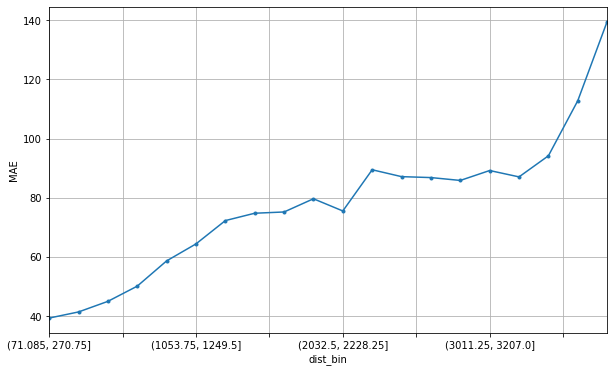

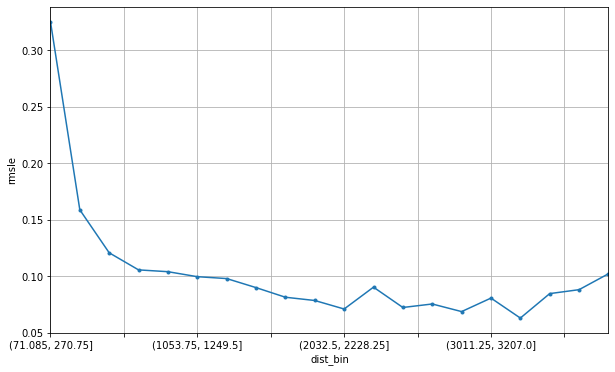

In [46]:
errors_nodist_speed.loc['loss_stats'].T.plot(figsize = (10 ,6 ), style ='.-')
plt.xlabel('dist_bin')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

errors_nodist_speed.loc['rmsle_stats'].T.plot(figsize = (10 ,6 ), style ='.-')
plt.xlabel('dist_bin')
plt.ylabel('rmsle')
plt.grid(True)


In [38]:
errors_nodist_speed

,"(71.085, 270.75]","(270.75, 466.5]","(466.5, 662.25]","(662.25, 858.0]","(858.0, 1053.75]","(1053.75, 1249.5]","(1249.5, 1445.25]","(1445.25, 1641.0]","(1641.0, 1836.75]","(1836.75, 2032.5]","(2032.5, 2228.25]","(2228.25, 2424.0]","(2424.0, 2619.75]","(2619.75, 2815.5]","(2815.5, 3011.25]","(3011.25, 3207.0]","(3207.0, 3402.75]","(3402.75, 3598.5]","(3598.5, 3794.25]","(3794.25, 3990.0]"
loss_stats,43.527040,45.129080,49.456179,56.774314,64.859484,74.433932,80.251887,88.670689,82.735997,91.006493,93.682746,98.562682,100.308449,99.364997,107.027599,107.680746,98.097407,122.169050,124.097368,167.599597
rmsle_stats,0.354173,0.173994,0.133717,0.119990,0.114670,0.117525,0.113943,0.114632,0.091463,0.102731,0.100329,0.100966,0.091595,0.088594,0.100332,0.094384,0.082366,0.115563,0.104592,0.122561


In [47]:
err = pd.concat([errors_nodist_speed, errors_nodist])

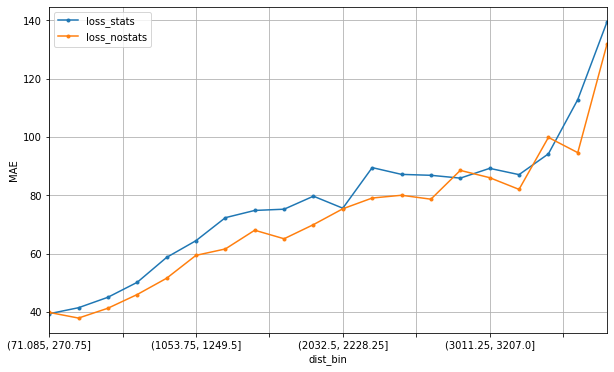

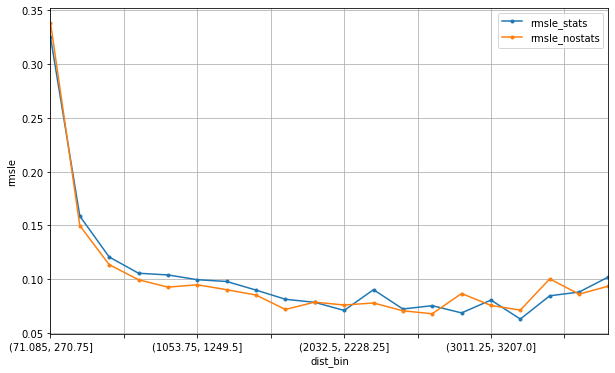

In [48]:
err.loc['loss_stats'].T.plot(figsize = (10 ,6 ), style ='.-')
err.loc['loss_nostats'].T.plot(figsize = (10 ,6 ), style ='.-')
plt.xlabel('dist_bin')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

err.loc['rmsle_stats'].T.plot(figsize = (10 ,6 ), style ='.-')
err.loc['rmsle_nostats'].T.plot(figsize = (10 ,6 ), style ='.-')
plt.xlabel('dist_bin')
plt.ylabel('rmsle')
plt.legend()
plt.grid(True)